# EDA of travel insurance prediction data

This notebook contains exploratory analysis that investigates insurance data

## Goals

- Which customers to target as they are more likely to buy travel insurance?
- How should I process the data?
- Which features should I include in model?
- Which machine learning algorithms show the most promise for prediction task?
- Which model and what hyperparameters to choose to predict travel insurance purchases?

**Null Hypothesis:** Annual income, frequent flying, and chronic diseases do not significantly affect travel insurance purchase likelihood.

**Alternative Hypothesis:** Annual income, frequent flying, and chronic diseases significantly affect travel insurance purchase likelihood.

## Data Set
The dataset contains information about customers, including demographics and travel history. The target variable is TravelInsurance which indicates whether a customer purchased travel insurance (1) or not (0).The data can be downloaded from [Kaggle](https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data)

## Biases

- Class imbalance: There is 2 times more customers who did not buy insurance than who did.
- Data is based on Tour and travel company customers, they might be different from general population and other insurance companies customers.
- This data focuses on travel insurance, which might be different from other types of insurance.


## Domain knowledge
I am not an insurance expert, but I will use statistical and machine learning knowledge to build a model to predict travel insurance purchases.

## Libraries

In [1]:
import time
import warnings

import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
from pygam import LogisticGAM, s
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from utils.evaluations import (
    create_model_comparison_table,
    evaluate_model,
    evaluate_model_cv,
)
from utils.plots import plot_categorical_vs_target, plot_linearity_check

warnings.filterwarnings("ignore")

## Get data

In [2]:
train_df = pd.read_csv("data/train_travel_insurance.csv")

## Display parameters

In [3]:
my_color = "skyblue"
pal = "coolwarm"

pal_insurance = dict(
    zip(
        [str(x) for x in train_df["TravelInsurance"].unique()],
        sns.color_palette("magma", n_colors=2),
        strict=False,
    )
)

## Data quality

In [4]:
train_df.head()

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,1027,25,Private Sector/Self Employed,No,1150000,5,0,Yes,No,0
1,990,29,Private Sector/Self Employed,Yes,600000,4,0,Yes,No,1
2,1550,28,Private Sector/Self Employed,Yes,1200000,7,0,No,No,0
3,18,29,Private Sector/Self Employed,Yes,1050000,5,1,No,No,1
4,1020,25,Private Sector/Self Employed,No,1150000,4,0,No,No,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1390 entries, 0 to 1389
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           1390 non-null   int64 
 1   Age                  1390 non-null   int64 
 2   Employment Type      1390 non-null   object
 3   GraduateOrNot        1390 non-null   object
 4   AnnualIncome         1390 non-null   int64 
 5   FamilyMembers        1390 non-null   int64 
 6   ChronicDiseases      1390 non-null   int64 
 7   FrequentFlyer        1390 non-null   object
 8   EverTravelledAbroad  1390 non-null   object
 9   TravelInsurance      1390 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 108.7+ KB


In [6]:
print(train_df.isna().sum())

Unnamed: 0             0
Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64


In [9]:
train_df[train_df["Employment Type"] == "Government Sector"]

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
5,1955,33,Government Sector,Yes,1750000,4,0,No,No,0
14,1618,28,Government Sector,Yes,300000,4,0,No,No,0
16,1285,26,Government Sector,Yes,500000,4,0,No,No,0
17,1828,28,Government Sector,Yes,300000,3,0,No,No,0
19,1363,28,Government Sector,Yes,600000,7,0,No,No,0
...,...,...,...,...,...,...,...,...,...,...
1360,233,31,Government Sector,Yes,1200000,6,1,No,No,0
1369,1631,33,Government Sector,Yes,1000000,3,0,No,No,0
1376,160,31,Government Sector,Yes,1200000,5,1,No,No,1
1379,185,28,Government Sector,Yes,300000,4,0,No,No,1


In [7]:
print(train_df.duplicated().sum())

0


# Distributions of features

Below I look into the distributions of features. I look for oultiers and strange inputs in data. Also I nvestigate the proportions of categorical features.

### Distribution of target variable

notice from below there is a class imbalance in the data, thus when I evaluate the model I will need to take this into account.

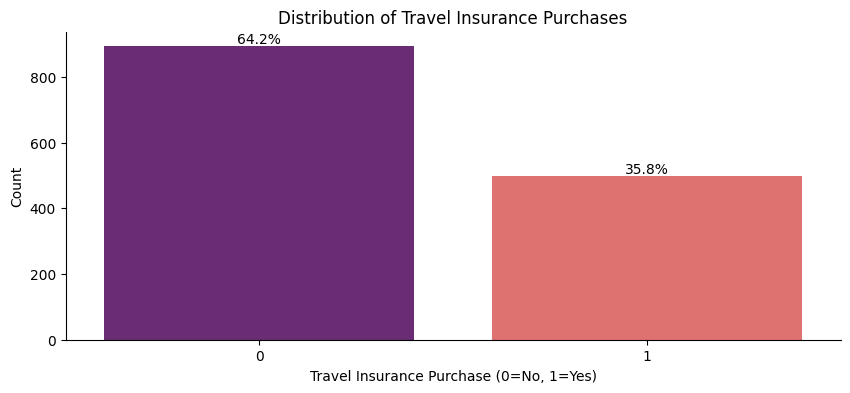

In [8]:
plt.figure(figsize=(10, 4))
ax = sns.countplot(data=train_df, x="TravelInsurance", palette=pal_insurance)
plt.title("Distribution of Travel Insurance Purchases")
plt.xlabel("Travel Insurance Purchase (0=No, 1=Yes)")
plt.ylabel("Count")

total = len(train_df)
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.1f}%"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha="center", va="bottom")

sns.despine()
plt.show()

### Distribution of Numerical Features

Notice from box plots below that there is no outliers in the data among numerical features.

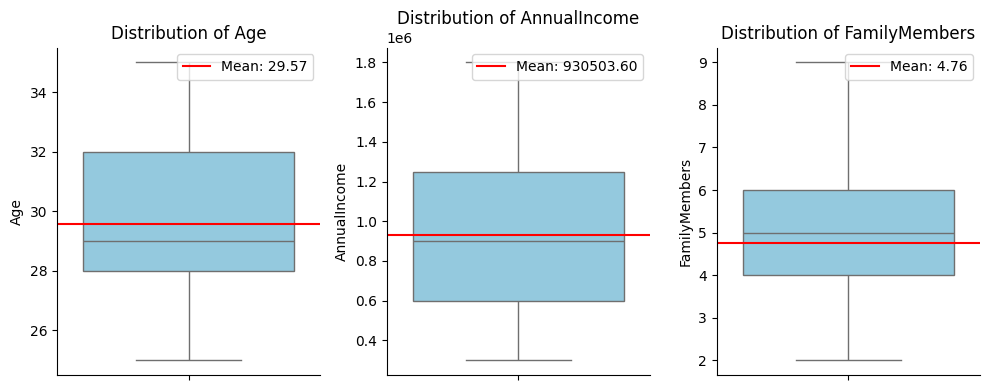

In [9]:
numerical_cols = ["Age", "AnnualIncome", "FamilyMembers"]

fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=train_df, y=col, color=my_color, ax=axes[i])
    mean_val = train_df[col].mean()
    axes[i].axhline(
        y=mean_val,
        color="red",
        linestyle="-",
        linewidth=1.5,
        label=f"Mean: {mean_val:.2f}",
    )
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel("")
    axes[i].legend(loc="upper right")
    sns.despine(ax=axes[i])

plt.tight_layout()
plt.show()

### Distribution of categorical features

All of the categorical features have no strange answers as all are binary.

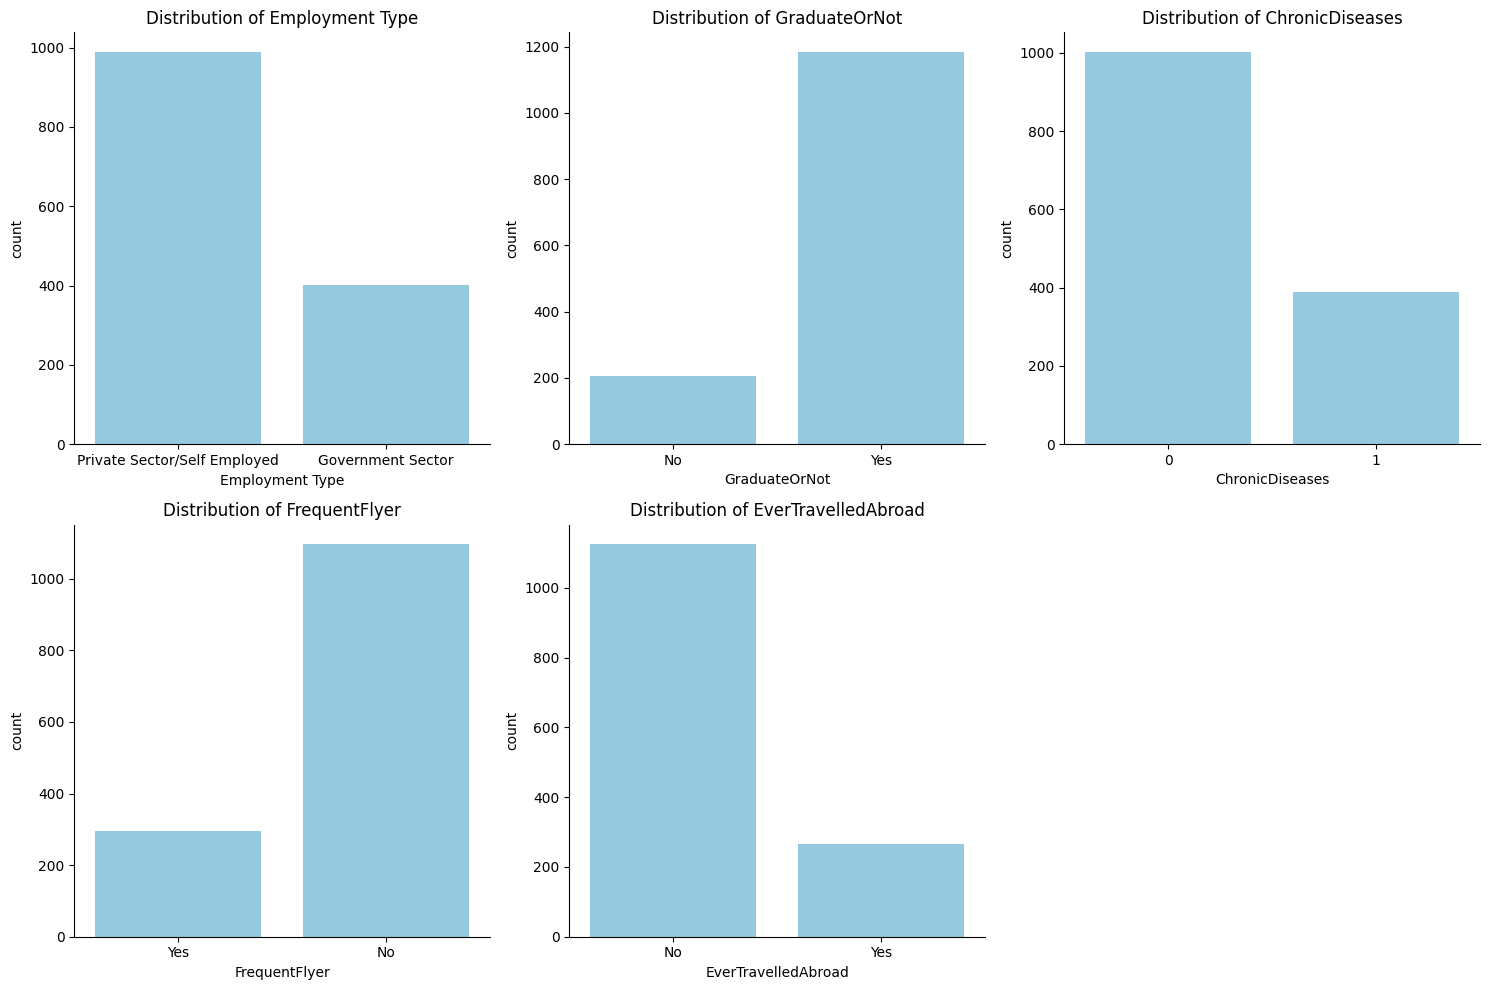

In [10]:
categorical_cols = [
    "Employment Type",
    "GraduateOrNot",
    "ChronicDiseases",
    "FrequentFlyer",
    "EverTravelledAbroad",
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=train_df, x=col, color=my_color, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].tick_params(axis="x")
    sns.despine(ax=axes[i])

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The data includes:
- More than 2 times more private sector employers than government sector employers
- 5 times more people who graduated than who did not
- More than 2 times more people without chronic diseases than with
- 4 times less frequent flyers than non-frequent flyers
- 3 times less people who have travelled abroad than who have not


### Bivariate Analysis

#### Numerical Features

- Notice there is bigger variance in age of those who buy insurance in the data compared to those who do not.
- Notice that anual income on averagr is 0.4 million higher for those who buy insurance.
- While famile numbers does not seem to have a big difference.

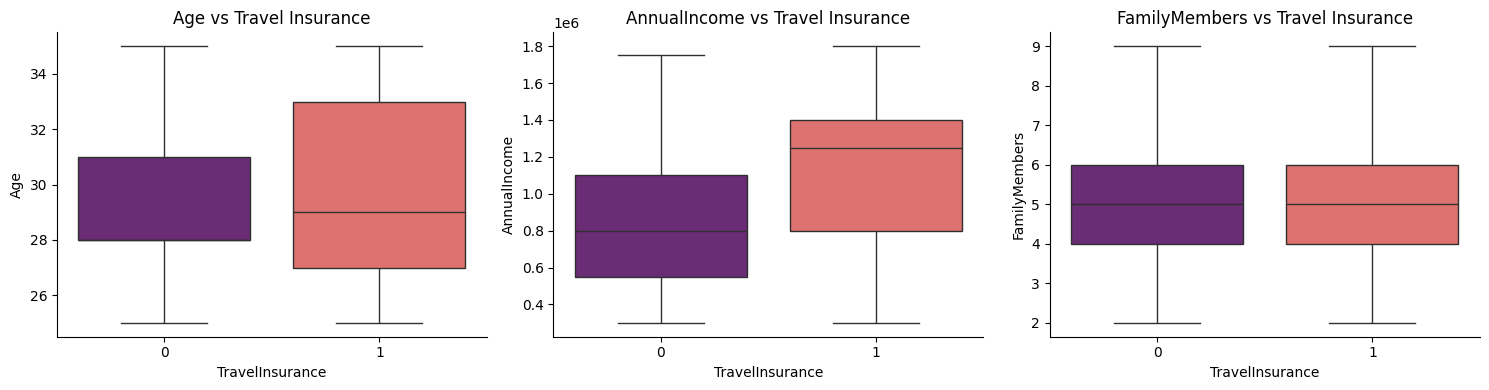

In [11]:
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(15, 4))
for i, col in enumerate(numerical_cols):
    sns.boxplot(
        data=train_df, x="TravelInsurance", y=col, ax=axes[i], palette=pal_insurance
    )
    axes[i].set_title(f"{col} vs Travel Insurance")
    sns.despine(ax=axes[i])
plt.tight_layout()
plt.show()

#### Categorical Features

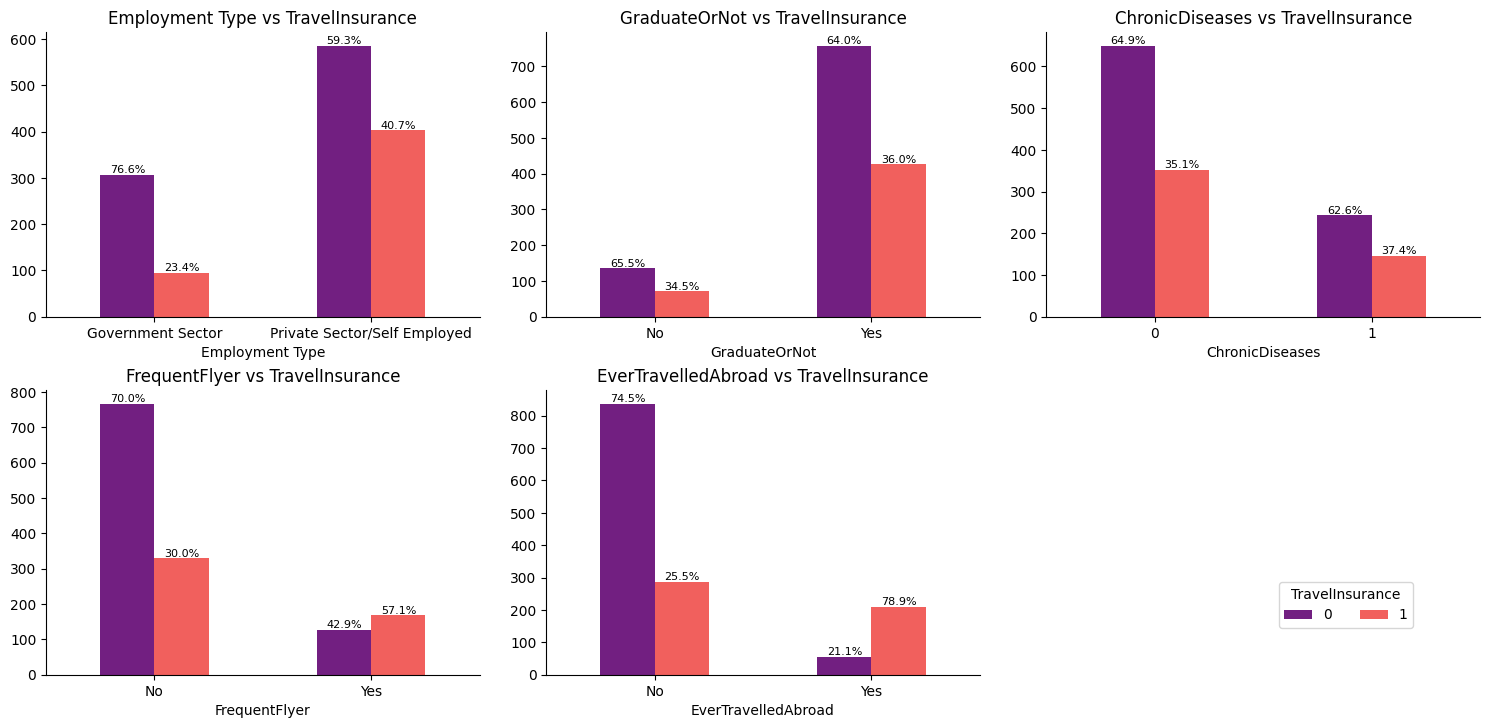

In [12]:
plot_categorical_vs_target(train_df, categorical_cols, "TravelInsurance", pal_insurance)

Note from the plot above:
- Private sector employees are almost 2 times more likely to buy insurance.
- Graduates and non-graduates have similar likelihood of buying insurance.
- People with chronic diseases and without chronic diseases have similar likelihood of buying insurance.
- People who are frequent flyers are almost 2 times more likely to buy insurance.
- People who have travelled abroad are 3 times more likely to buy insurance..


### Pearson correlation Analysis

here I look at the correlation between features. First I drop the unnamed column as it is not a feature.

In [13]:
train_without_unnamed_df = train_df.drop("Unnamed: 0", axis=1)

Here I make a copy of the dataframe and convert the categorical variables to numeric.

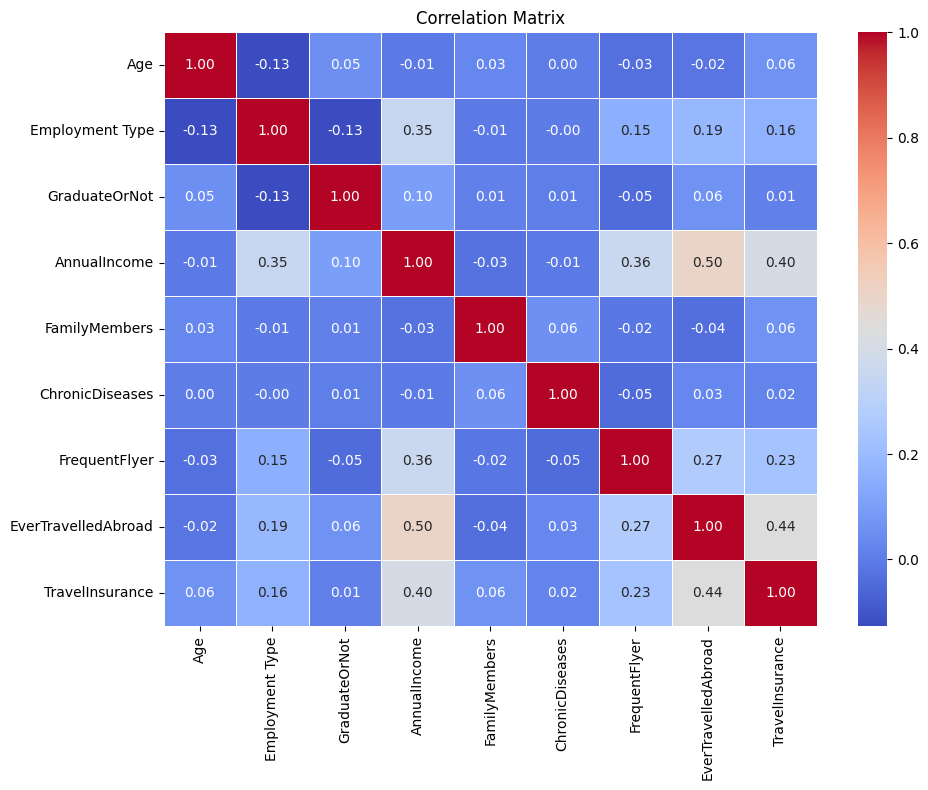

In [14]:
corr_df = train_without_unnamed_df.copy()
for col in categorical_cols:
    corr_df[col] = pd.get_dummies(corr_df[col], drop_first=True)

corr_matrix = corr_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap=pal, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

Here note that AnnualIncome, EverTravelledAbroad and FrequentFlyer are highly correlated with TravelInsurance (0.4, 0.44 and 0.23 respectively). Note that there is also correlation between AnnualIncome and EverTravelledAbroad, FrequentFlyer, but they are not strong correlations (0.5, 0.36 respectively).

But note that this data is not scaled thus AnnualIncome will have a bigger impact on the model due to its larger scale. 

## Logistic regression assumptions

Below shows that FamilyMembers feature does 

# Process Data
In this section we prepare the data for modeling by handling categorical features, missing values, and scaling numerical features.

I need StandardScaler because it normalizes numerical features to have zero mean and unit variance, which prevents features with larger scales (like AnnualIncome) from dominating those with smaller scales (FamilyMembers). Without scaling, model might be biased toward features with larger numerical ranges.

There is no missing values in the data, but I still leave the imputers for now, but I will use the median for numerical and most frequent value for categorical features as they might come up in test data.

I do one-hot encoding for the categorical features and drop the first category.

Also I drop the unnamed column as it is not a feature.

In [15]:
numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="first", sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, ["Age", "AnnualIncome", "FamilyMembers"]),
        (
            "cat",
            categorical_transformer,
            [
                "Employment Type",
                "GraduateOrNot",
                "FrequentFlyer",
                "EverTravelledAbroad",
                "ChronicDiseases",
            ],
        ),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

Above I defined preprocessor now I process the data below

In [16]:
X_train = train_df.drop("TravelInsurance", axis=1)
y_train = train_df["TravelInsurance"]
X_train_processed = preprocessor.fit_transform(X_train)
X_train_processed_df = pd.DataFrame(
    X_train_processed, columns=preprocessor.get_feature_names_out()
)

below notice numerical values are centered at 0 and have unit variance which can be seen from the box plots below

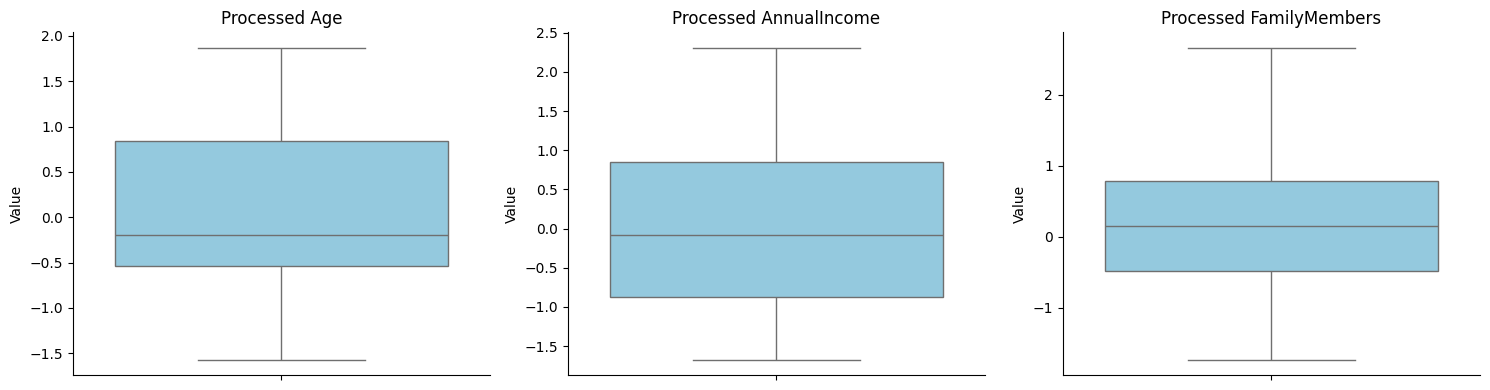

In [17]:
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(15, 4))
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=X_train_processed_df[col], color=my_color, ax=axes[i])
    axes[i].set_title(f"Processed {col}")
    axes[i].set_ylabel("Value")
    sns.despine(ax=axes[i])
plt.tight_layout()
plt.show()

### Data Processing Summary
I have prepared our data by:
1. Handling any missing values with median for numerical and most frequent value for categorical features
2. Encoding categorical variables using one-hot encoding (dropping the first category to avoid multicollinearity)
3. Scaling numerical features to have zero mean and unit variance
4. Creating a reusable pipeline to apply the same transformations to training, validation and test data

# Feature Selection
In this section, I will analyze feature relationships and select the most relevant features for our model.

### Correlation with target
First, let's examine correlations between features and our target variable.

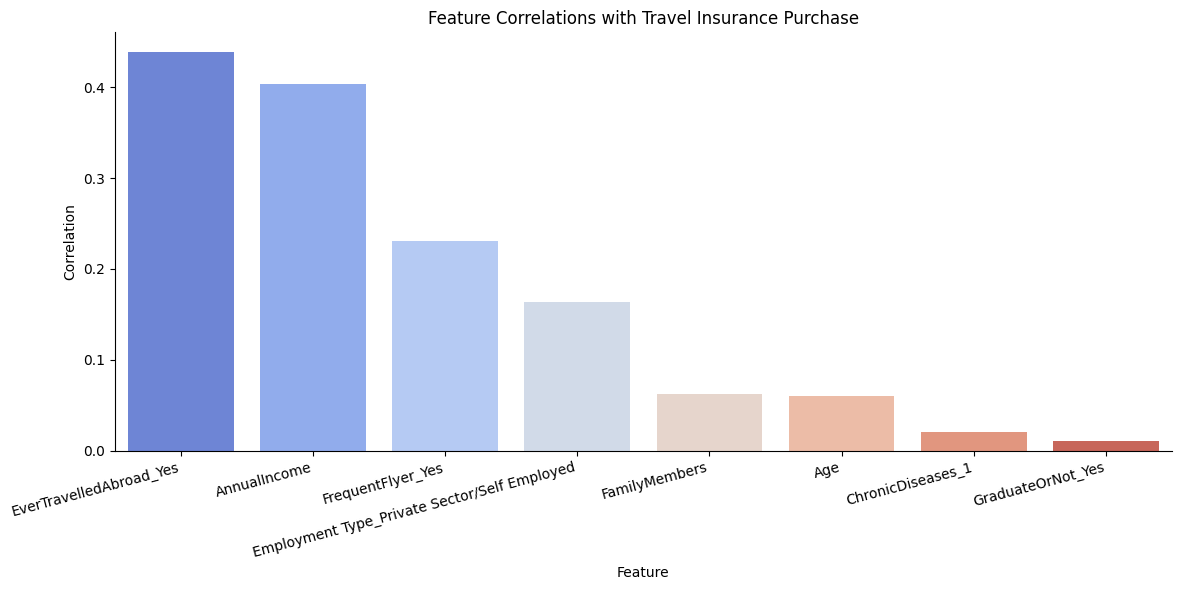

Correlations with target:
                                        Feature  Correlation  Abs_Correlation
6                       EverTravelledAbroad_Yes     0.438401         0.438401
1                                  AnnualIncome     0.403796         0.403796
5                             FrequentFlyer_Yes     0.231121         0.231121
3  Employment Type_Private Sector/Self Employed     0.163600         0.163600
2                                 FamilyMembers     0.062953         0.062953
0                                           Age     0.060150         0.060150
7                             ChronicDiseases_1     0.020978         0.020978
4                             GraduateOrNot_Yes     0.011221         0.011221


In [18]:
correlation_with_target = []
for column in X_train_processed_df.columns:
    corr = X_train_processed_df[column].corr(y_train)
    correlation_with_target.append(
        {"Feature": column, "Correlation": corr, "Abs_Correlation": abs(corr)}
    )

corr_df = pd.DataFrame(correlation_with_target).sort_values(
    "Abs_Correlation", ascending=False
)

plt.figure(figsize=(12, 6))
sns.barplot(x="Feature", y="Correlation", data=corr_df, palette=pal)
plt.xticks(rotation=15, ha="right")
plt.title("Feature Correlations with Travel Insurance Purchase")
plt.tight_layout()
sns.despine()
plt.show()

print("Correlations with target:")
print(corr_df)

### Multicollinearity Analysis
We'll use Variance Inflation Factor (VIF) to detect multicollinearity among features. It seems it is not a problem here as none of the features have VIF greater than 5. Thus I leave all features.

In [19]:
def calculate_vif(x: pd.DataFrame) -> pd.DataFrame:
    """Calculate VIF for each feature."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = x.columns
    vif_data["VIF"] = [
        variance_inflation_factor(x.values, i) for i in range(x.shape[1])
    ]
    return vif_data.sort_values("VIF", ascending=False)


vif_results = calculate_vif(X_train_processed_df)
print("Variance Inflation Factors:")
print(vif_results)

Variance Inflation Factors:
                                        Feature       VIF
4                             GraduateOrNot_Yes  2.694300
3  Employment Type_Private Sector/Self Employed  2.659579
6                       EverTravelledAbroad_Yes  1.653980
5                             FrequentFlyer_Yes  1.431113
1                                  AnnualIncome  1.391911
7                             ChronicDiseases_1  1.354185
0                                           Age  1.018085
2                                 FamilyMembers  1.005568


### Feature Importance Analysis
Let's use a Random Forest model to assess feature importance. Suprisingly Employment Type and GraduateOrNot are not among the most important features that correlation analysis showed. Age and family members seems to be more important.

Feature importance from Random Forest:
                                        Feature  Importance
1                                  AnnualIncome    0.424121
2                                 FamilyMembers    0.194140
0                                           Age    0.176250
6                       EverTravelledAbroad_Yes    0.097658
7                             ChronicDiseases_1    0.035520
5                             FrequentFlyer_Yes    0.035494
3  Employment Type_Private Sector/Self Employed    0.020836
4                             GraduateOrNot_Yes    0.015981


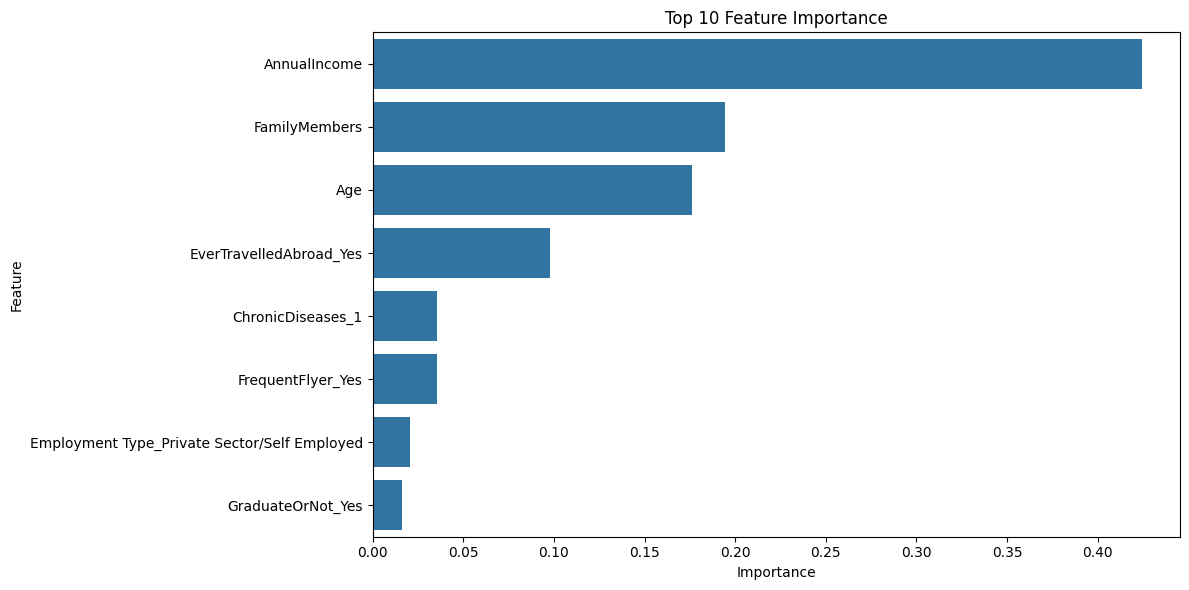

In [20]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_processed_df, y_train)

feature_importance = pd.DataFrame(
    {"Feature": X_train_processed_df.columns, "Importance": rf.feature_importances_}
).sort_values("Importance", ascending=False)

print("Feature importance from Random Forest:")
print(feature_importance.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance.head(10))
plt.title("Top 10 Feature Importance")
plt.tight_layout()
plt.show()

### Dimensionality Reduction Assessment

PCA is dimensionality reduction technique that is used to reduce the number of features in the data. It shows cumulative explained variance which helps to identify how many components are needed to explain a certain percentage of variance.

As I can see from below I need 7 components to explain 95% of variance. As I did not find any multicollinearity in the data, I will keep all features. But note that reducing the number of features might mitigate overfitting, simplifying the model and improving interpretability. This might be a good idea to try if the model is overfitting.

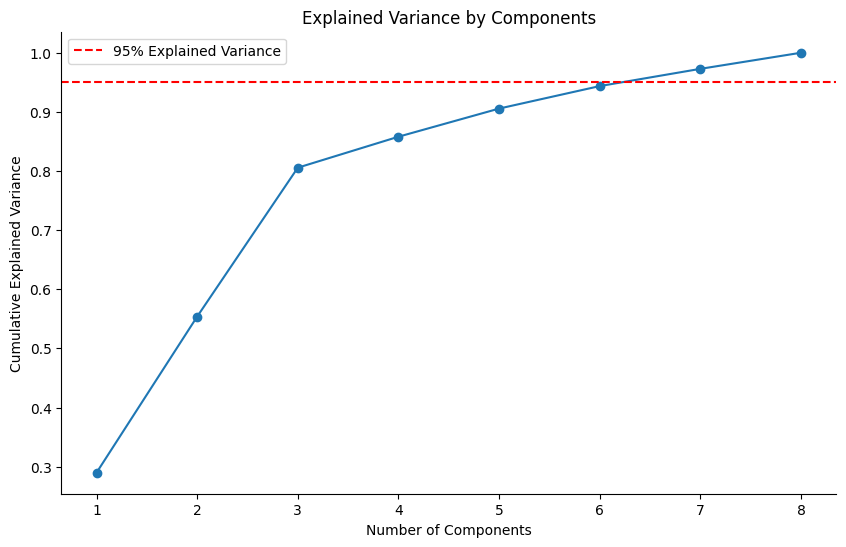

Number of components needed to explain 95% of variance: 7


In [21]:
pca = PCA()
pca.fit(X_train_processed_df)

plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    np.cumsum(pca.explained_variance_ratio_),
    marker="o",
)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(y=0.95, color="r", linestyle="--", label="95% Explained Variance")
plt.title("Explained Variance by Components")
plt.legend()
sns.despine()
plt.show()

n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1  # noqa: PLR2004
print(f"Number of components needed to explain 95% of variance: {n_components}")

# Hypothesis testing

To test my hypothesis I intended to use logistic regression.

**Null Hypothesis:** Annual income, frequent flying, and chronic diseases do not significantly affect travel insurance purchase likelihood.

**Alternative Hypothesis:** Annual income, frequent flying, and chronic diseases significantly affect travel insurance purchase likelihood.

## Logistic regression assumptions
- Linearity of the log-odds ratio (I will check for this below)
- Independent observations (each row is a person thus it is independently observed)
- No multicollinearity (I checked for this above using VIF and correlations between features are less than 3)
- Sufficient sample size (1688 observations)
- Absence of outliers (I have checked for this above and there is no outliers)

### Linearity of the log-odds ratio

- **Null hypothesis**: The log-odds ratio is linear with the features.
- **Alternative hypothesis**: The log-odds ratio is not linear with the features.

Once I’ve already accounted for a straight-line effect with feature x I add non-linear transformation of x (say 𝑥 log(x) as i did below) and ask does this extra nonlinear piece still matter by fitting logistic regression model again?
At confidence level 0.05 I stay with Null hypothesis with FamilyMembers (FamilyMembers_log=0.07 > 0.05) feature as it does not matter while I reject it for Age and AnnualIncome (Age_log~=0.0000 < 0.05, AnnualIncome_log~=0.0000 < 0.05). 

Thus for Age and AnnualIncome I will use GAM (Generalized Additive Model which looks for non-linear relationships between features and target) to check whether continious features are significant. While for categorical features I will use Logistic Regression.

In [22]:
X_train = train_df.drop("TravelInsurance", axis=1)
y_train = train_df["TravelInsurance"]
X = X_train.copy().reset_index(drop=True)
y = y_train.copy().reset_index(drop=True)

continuous_vars = ["Age", "AnnualIncome", "FamilyMembers"]
X = X[continuous_vars]
X[continuous_vars] = X[continuous_vars].replace(0, 1e-5)

for var in continuous_vars:
    X[f"{var}_log"] = X[var] * np.log(X[var])

X_with_const = sm.add_constant(X)
model = sm.Logit(y, X_with_const)
results = model.fit()
print(results.summary2())

Optimization terminated successfully.
         Current function value: 0.535245
         Iterations 6
                           Results: Logit
Model:               Logit             Method:            MLE       
Dependent Variable:  TravelInsurance   Pseudo R-squared:  0.179     
Date:                2025-05-20 12:54  AIC:               1501.9819 
No. Observations:    1390              BIC:               1538.6413 
Df Model:            6                 Log-Likelihood:    -743.99   
Df Residuals:        1383              LL-Null:           -906.28   
Converged:           1.0000            LLR p-value:       4.4151e-67
No. Iterations:      6.0000            Scale:             1.0000    
--------------------------------------------------------------------
                   Coef.   Std.Err.    z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------------
const              80.9178  14.7012  5.5042 0.0000  52.1040 109.7317
Age               -11.8496  

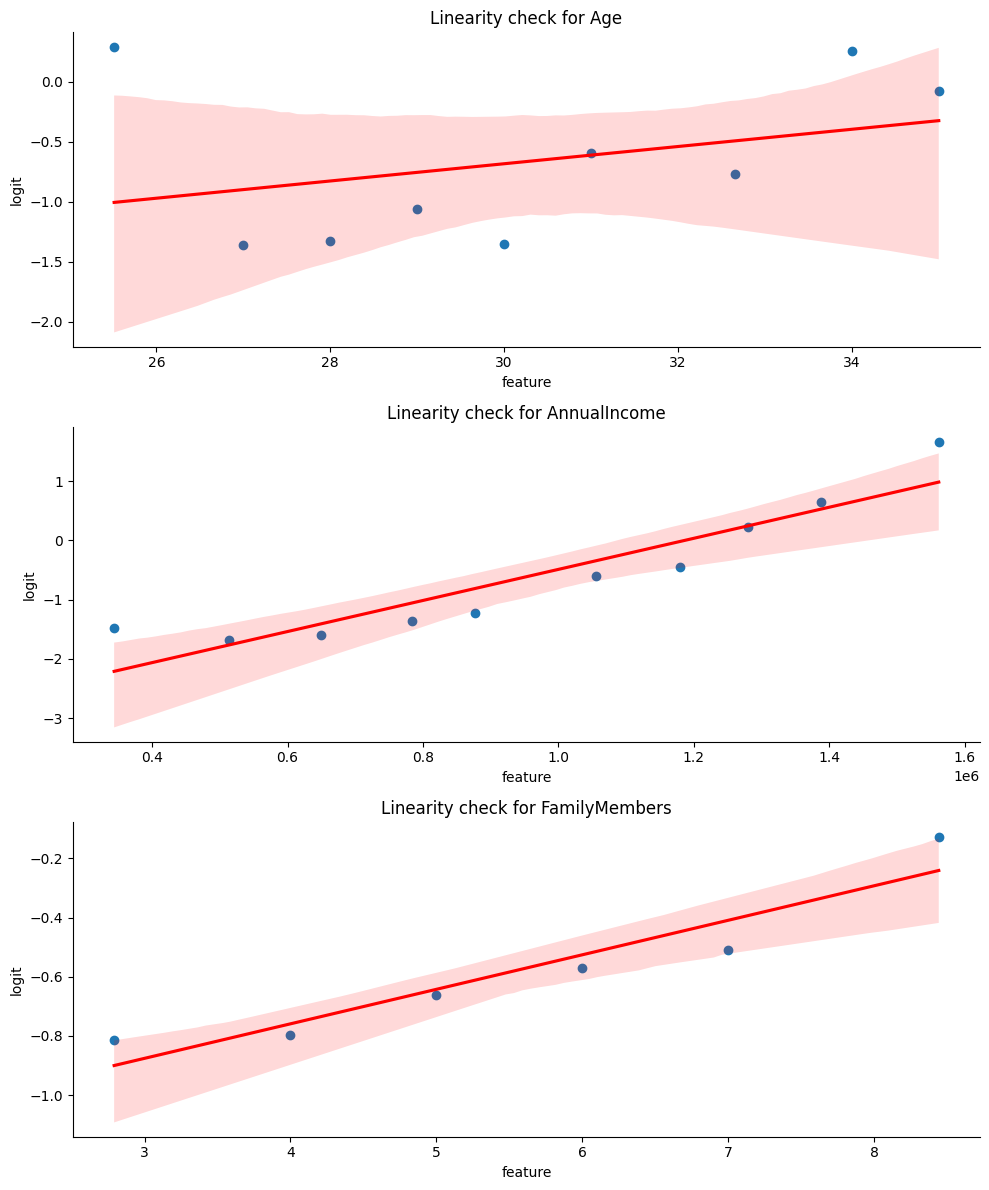

In [23]:
y_pred = results.predict(X_with_const)
plot_linearity_check(X, y_pred, ["Age", "AnnualIncome", "FamilyMembers"])

## Continous Features

As I have found that Age and AnnualIncome are not linear with the target variable, I will use GAM to check whether they are significant in non-linear way.

From below I can see that GAM says that Age, AnnualIncome and FamilyMembers have significant effect on whether a customer will buy travel insurance at 5% significance level. Note that this method tends to have lower p-values than in reality, but as the p-values are below 0.000, I will trust the results.

For more robust results I recommend transforming the data according to the results of GAM and then fitting the logistic regression model again this way satisfying the linearity of the log-odds ratio assumption.

In [24]:
X_train = train_df.drop("TravelInsurance", axis=1)
y_train = train_df["TravelInsurance"].to_numpy()
continuous_vars = ["Age", "AnnualIncome", "FamilyMembers"]
X = X_train[continuous_vars].copy()
X = X.replace(0, 1e-5)
X_np = X.to_numpy()

gam = LogisticGAM(s(0) + s(1) + s(2))
gam.fit(X_np, y_train)
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     26.2756
Link Function:                        LogitLink Log Likelihood:                                  -644.1684
Number of Samples:                         1390 AIC:                                              1340.888
                                                AICc:                                            1342.0207
                                                UBRE:                                               2.9798
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2892
Feature Function                  Lam

Below are the plots of continious variables relationship with predictions log odds ratio. The higher the y axis value the more likely the customer will buy insurance.

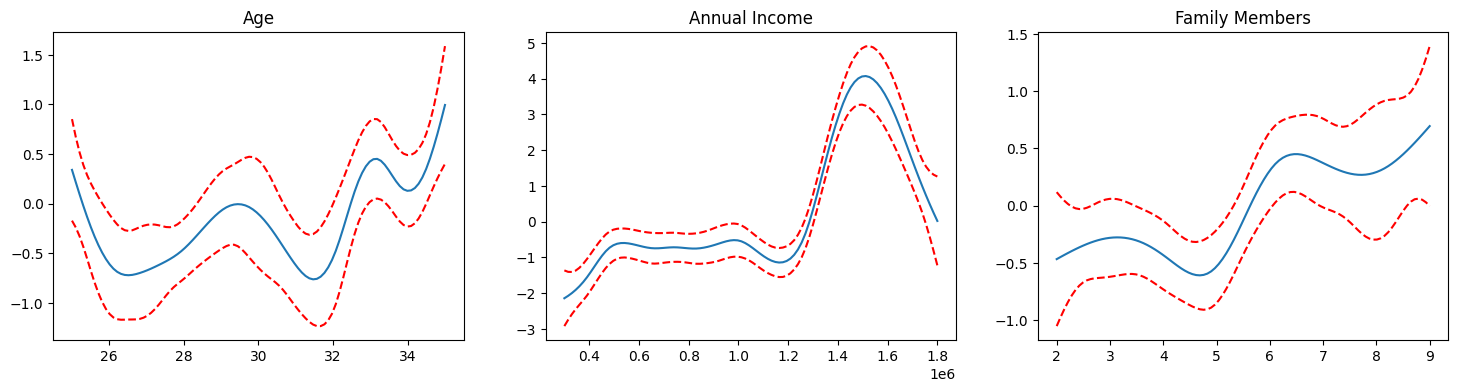

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
titles = ["Age", "Annual Income", "Family Members"]

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(
        XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], c="r", ls="--"
    )
    ax.set_title(titles[i])

## Categorical Features

**Null hypothesis**: The categorical feature is not significant.
**Alternative hypothesis**: The categorical feature is significant.

I use Logistic Regression to check whether categorical features are significant at 5% significance level. From below notice that ChronicDiseases and GraduateOrNot are not significant with p-values (0.51 and 0.91 respectively) thus I stay with Null hypothesis. While for other categorical features I reject the null hypothesis.

In [26]:
X_train = train_df.drop("TravelInsurance", axis=1)
y_train = train_df["TravelInsurance"]

X_train_processed = preprocessor.fit_transform(X_train)
X_train_processed_df = pd.DataFrame(
    X_train_processed, columns=preprocessor.get_feature_names_out()
)
X_with_const = sm.add_constant(X_train_processed_df)
X_without_continuous = X_with_const.drop(
    ["Age", "AnnualIncome", "FamilyMembers"], axis=1
)
model = sm.Logit(y_train, X_without_continuous)
results = model.fit()
print(results.summary2())

Optimization terminated successfully.
         Current function value: 0.546538
         Iterations 5
                                       Results: Logit
Model:                       Logit                     Method:                    MLE       
Dependent Variable:          TravelInsurance           Pseudo R-squared:          0.162     
Date:                        2025-05-20 12:54          AIC:                       1531.3757 
No. Observations:            1390                      BIC:                       1562.7981 
Df Model:                    5                         Log-Likelihood:            -759.69   
Df Residuals:                1384                      LL-Null:                   -906.28   
Converged:                   1.0000                    LLR p-value:               2.9316e-61
No. Iterations:              5.0000                    Scale:                     1.0000    
--------------------------------------------------------------------------------------------
       

## Hypothesis summary

For continious features in our case AnnualIncome I found this feature is not log odds ratio linear with target variable thus I couldn't use Logistic Regression. Thus I used GAM to check whether it is significant in non-linear way and found that it is significant at 5% significance level.

For categorical features I used Logistic Regression and found that ChronicDiseases is not significant with p-values (0.51) thus I stay with Null hypothesis. While frequent flyer is significant with p-values (0.000) thus I reject the null hypothesis.

# Model Building
In this section, we'll train multiple classification models and compare their performance. First lets import validation data.

In [27]:
val_df = pd.read_csv("data/val_travel_insurance.csv")
X_val = val_df.drop("TravelInsurance", axis=1)
y_val = val_df["TravelInsurance"]
X_val_processed = preprocessor.transform(X_val)
X_val_processed_df = pd.DataFrame(
    X_val_processed, columns=preprocessor.get_feature_names_out()
)

Now I will choose 8 models to compare their performance.

In [28]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "CatBoost": catboost.CatBoostClassifier(
        n_estimators=100, random_state=42, verbose=False
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
}

Now I will train the models 

In [29]:
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    results[name] = evaluate_model(
        model, X_train_processed_df, X_val_processed_df, y_train, y_val
    )

Training Logistic Regression...
Training SVM...
Training Random Forest...
Training XGBoost...


Training Gradient Boosting...
Training CatBoost...
Training KNN...
Training Naive Bayes...


Now I will print the results of the models.

In [30]:
create_model_comparison_table(results)

,Model,Accuracy,Precision,Recall,F1 Score,AUC
4,Gradient Boosting,0.812081,0.867647,0.556604,0.678161,0.777098
3,XGBoost,0.788591,0.759036,0.594340,0.666667,0.762161
5,CatBoost,0.808725,0.876923,0.537736,0.666667,0.751990
2,Random Forest,0.771812,0.720930,0.584906,0.645833,0.743072
1,SVM,0.791946,0.823529,0.528302,0.643678,0.769089
6,KNN,0.755034,0.703704,0.537736,0.609626,0.737176
7,Naive Bayes,0.728188,0.666667,0.471698,0.552486,0.707621
0,Logistic Regression,0.738255,0.733333,0.415094,0.530120,0.733957


- Precision focuses on the correct positive predictions.
example: 0.868 means 86.8% of customers predicted to buy insurance actually did
- Recall measures how well the model identifies all positive cases.
example: 0.557 means we identified 55.7% of customers who actually bought insurance
- f1 score is single metric that balances precision and recall.
- AUC is probability that your model will rank a randomly chosen positive example higher than a randomly chosen negative example.
example: 0.77 means 77% of the time, the model will rank a positive example higher than a negative example.

In our case, we want to maximize precision as we dont want to target customers who are not likely to buy insurance and recall as we dont want to miss any customers who are likely to buy insurance. Depending on targeting costs we could consider optimizing for recall.

I will choose Gradient boosting as it is most balanced model according to F1 score and xgboost as it maximizes recall. 

### ROC Curves

Below is the ROC curve for the models. A ROC curve shows how well your model can distinguish between positive and negative cases:
- x axis shows false positive rate
- y axis shows true positive rate
- Random model is represented by the diagonal line
- Models with higher AUC (area under the curve) are better at distinguishing between positive and negative cases.

In our case the best ones is Gradient Boosting and SVM with XGBoost trailing right behind.


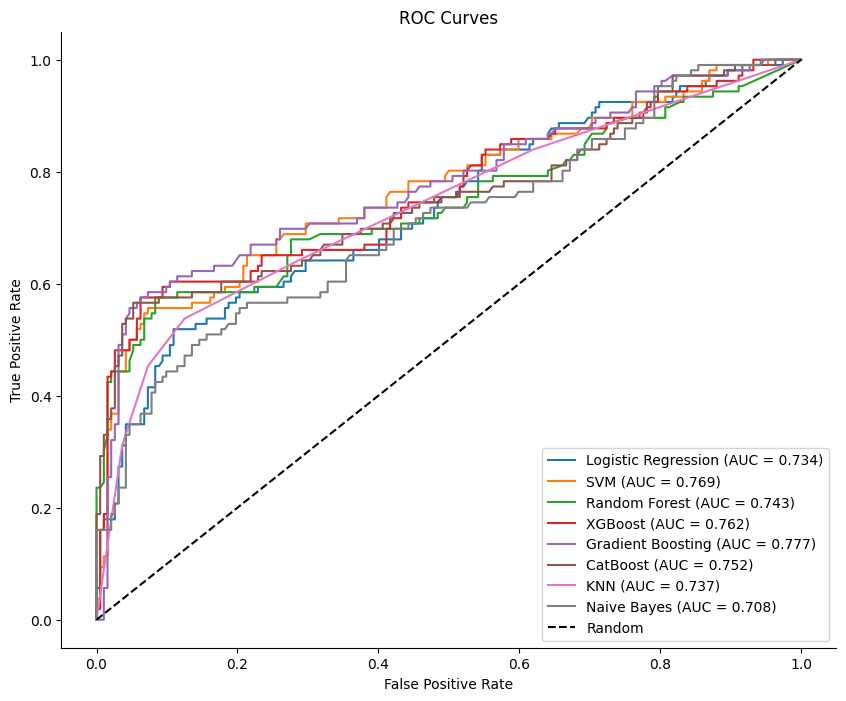

In [31]:
plt.figure(figsize=(10, 8))

for name, result in results.items():
    if result["auc"] is not None:
        model = result["model"]
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_val_processed_df)[:, 1]
            fpr, tpr, _ = roc_curve(y_val, y_proba)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {result['auc']:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="best")
sns.despine()
plt.show()

# Tune 2 Best Models

Here to tune I will use combined training and validation sets as I will cross validate them. 

I will tune Gradient Boosting to maximize F1 score and XGBoost to maximize recall.

In [34]:
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])

#### Gradient Boosting

In [35]:
pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", GradientBoostingClassifier(random_state=42)),
    ]
)

gb_param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__max_depth": [3, 5],
}

gb_grid = GridSearchCV(
    pipeline,
    param_grid=gb_param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
)

gb_grid.fit(X_combined, y_combined)
print(f"Best parameters: {gb_grid.best_params_}")
print(f"Best F1 score: {gb_grid.best_score_:.4f}")

best_gb_model = gb_grid.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Best F1 score: 0.7172


Best parameters for Gradient Boosting are n_estimators=100, learning_rate=0.1, max_depth=3.

#### XGBoost

In [38]:
pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", xgb.XGBClassifier(random_state=42, eval_metric="logloss")),
    ]
)


xgb_param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__max_depth": [3, 5],
}
start_time = time.time()
xgb_grid = GridSearchCV(
    pipeline,
    param_grid=xgb_param_grid,
    cv=5,
    scoring="recall",
    n_jobs=-1,
    verbose=1,
)

print("Tuning XGBoost...")
xgb_grid.fit(X_combined, y_combined)

elapsed_time = time.time() - start_time
print(f"Search completed in {elapsed_time:.2f} seconds")
print(f"Best parameters: {xgb_grid.best_params_}")
print(f"Best recall score: {xgb_grid.best_score_:.4f}")

best_xgb_model = xgb_grid.best_estimator_

Tuning XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


Search completed in 10.50 seconds
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Best recall score: 0.6087


Best parameters for XGBoost are n_estimators=200, learning_rate=0.1, max_depth=5.

### Cross Validation

In this section I will evaluate the 2 tuned models on the combined training and validation sets.

In [33]:
models = {
    "Gradient Boosting": xgb.XGBClassifier(
        learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42
    ),
    "XGBoost": xgb.XGBClassifier(
        learning_rate=0.1, max_depth=5, n_estimators=200, random_state=42
    ),
}

Here I train the models

In [34]:
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    results[name] = evaluate_model_cv(model, X_combined, y_combined)

Training Gradient Boosting...
Training XGBoost...


Below is code for printing the results of cross validation.

In [35]:
create_model_comparison_table(results)

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Gradient Boosting,0.834123,0.917313,0.588723,0.717172,0.799030
1,XGBoost,0.818720,0.839817,0.608624,0.705769,0.804428


- Accuracy: Percentage of all predictions that are correct.
For Gradient Boosting: 83.4% of all predictions were correct
- Precision: When model predicts positive, how often is it actually positive.
For XGBoost: 84.0% of positive predictions were truly positive
- Recall: Percentage of actual positives that were correctly identified.
For Gradient Boosting: Only 58.9% of actual positives were caught
- F1 Score: Harmonic mean of precision and recall.
For XGBoost: 0.706 (balances precision/recall)
- AUC is the probability that a randomly chosen positive example will rank higher than a randomly chosen negative example.
For XGBoost: 0.804 (better at ranking predictions)

In our case, I want to maximize recall as we dont want to miss any customers who are likely to buy insurance. Xgboost has better recall by 2% than Gradient Boosting, but lower precision by 9%. This can be interpreted as for one more customer correctly predicted, XGboost misclassifies a little less than 5 customers. As I believe aquaring customer overweights the cost of misclassifying 5 customers, I will choose XGBoost. This might depend on the business goals and costs.

# Conclusions

As this is exploratory analysis I will go through initialy raised questions and hypothesis:

Hypothesis: I reject null hypothesis for AnnualIncome, FrequentFlyer i.e. they significantly affect travel insurance purchase likelihood, while I stay with null hypothesis for ChronicDiseases with confidence level 0.05.

1. Which customers to target as they are more likely to buy travel insurance?
    - Private sector employees are almost 2 times more likely to buy insurance.
    - Graduates and non-graduates have similar likelihood of buying insurance.
    - People with chronic diseases and without chronic diseases have similar likelihood of buying insurance.
    - People who are frequent flyers are almost 2 times more likely to buy insurance.
    - People who have travelled abroad are 3 times more likely to buy insurance.
    - Notice there is bigger variance in age of those who buy insurance in the data compared to those who do not.
    - Annual income on average is 0.4 million higher for those who buy insurance.
    - While family numbers does not seem to have a big influence on buying insurance.

2.  How should I process the data?
     - Remove unnamed column as it is not a feature.
     - Handling any missing values with median for numerical and most frequent value for categorical features. Note that training data has no missing values, this is just in case there is any missing values in test data.
     - Encoding categorical variables using one-hot encoding, this preserves categorical nature of the data without imposing any numerical ordering that models might interpret as meaningful.
     - Scaling numerical features to have zero mean and unit variance, this is to prevent features with larger scales from dominating those with smaller scales.
     - Created a reusable pipeline to apply the same transformations to training, validation and test data.

3. Which features should I include in model?
    - I took a look at correlation of features with target variable of which top 3 were AnnualIncome, EverTravelledAbroad and FrequentFlyer.
    - Multicollinearity was not an issue as none of the features have VIF greater than 5.
    - I also took a look at feature importance of Random Forest model which showed that Annual income, Age, Family members and EverTravelledAbroad are the most important features.
    - I investigated PCA to see how many components are needed to explain 95% of variance which showed that I need 7 components.
    - As I did not find any multicollinearity in the data, and all features have correlation with target variable, I will keep all 8 features. If there is signs of overfitting, I can reduce number of features.

4. Which machine learning algorithms show the most promise for prediction task?
    - I chose 8 models to compare their performance. Found Gradient Boosting and XGBoost showed the best performance in terms of f1 score and recall respectively.
    - I tuned Gradient Boosting to maximize F1 score and XGBoost to maximize recall.
    - XGBoost has better recall by 2% than Gradient Boosting, but lower precision by 9% than Gradient Boosting.

5. Which model and what hyperparameters to choose?
    - I believe higher recall by 2% in XGBoost justifies loss in precision by 9% when compared to Gradient Boosting. Thus I choose XGBoost as final prediction model. Although Gradient Boosting has better balance between metrics and remains alternative to XGBoost.
    - Final model is XGBoost with n_estimators=200, learning_rate=0.1, max_depth=5.